<center><h1>Decision Trees & The LASSO and Boosting for Regression</h1></center>
<br>
<br>

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import _tree
from sklearn import datasets
from sklearn import tree

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
column_names = ['Temperature of patient', 'Occurrence of nausea', 'Lumbar pain','Urine pushing (continuous need for urination)',
               'Micturition pains','Burning of urethra, itch, swelling of urethra outlet','decision: Inflammation of urinary bladder',
               'decision: Nephritis of renal pelvis origin'] 
Accute_Inflamations_data = pd.read_csv('../Data/diagnosis.csv', sep='\t', header=None, names=column_names, encoding='utf-16')
Accute_Inflamations_data["Temperature of patient"] = Accute_Inflamations_data["Temperature of patient"].str.replace(',', '.').astype(float)

In [3]:
print(Accute_Inflamations_data.shape)
Accute_Inflamations_data.head()

(120, 8)


,Temperature of patient,Occurrence of nausea,Lumbar pain,Urine pushing (continuous need for urination),Micturition pains,"Burning of urethra, itch, swelling of urethra outlet",decision: Inflammation of urinary bladder,decision: Nephritis of renal pelvis origin
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


### (b) Build a decision tree

In [4]:
# Convert all categorical columns to numeric
categorical_columns = [
    "Occurrence of nausea", 
    "Lumbar pain", 
    "Urine pushing (continuous need for urination)", 
    "Micturition pains", 
    "Burning of urethra, itch, swelling of urethra outlet",
    "decision: Inflammation of urinary bladder",
    "decision: Nephritis of renal pelvis origin"
]

for column in categorical_columns:
    Accute_Inflamations_data[column] = Accute_Inflamations_data[column].map({"no": 0, "yes": 1})

# features (X) and variables (y_inflammation, y_nephritis)
X = Accute_Inflamations_data.drop(columns=["decision: Inflammation of urinary bladder", 
                                           "decision: Nephritis of renal pelvis origin"])
y_inflammation = Accute_Inflamations_data["decision: Inflammation of urinary bladder"]
y_nephritis = Accute_Inflamations_data["decision: Nephritis of renal pelvis origin"]

# decision tree classifiers
clf_inflammation = DecisionTreeClassifier(random_state=42)
clf_nephritis = DecisionTreeClassifier(random_state=42)

# Fit the model
clf_inflammation.fit(X, y_inflammation)
clf_nephritis.fit(X, y_nephritis)

# combined decision column
Accute_Inflamations_data["combined_decision"] = y_inflammation.astype(str) + y_nephritis.astype(str)
y_combined = Accute_Inflamations_data["combined_decision"].factorize()[0]

# Decision tree classifier for the combined decision
clf_combined = DecisionTreeClassifier(random_state=42)
clf_combined.fit(X, y_combined)

DecisionTreeClassifier(random_state=42)

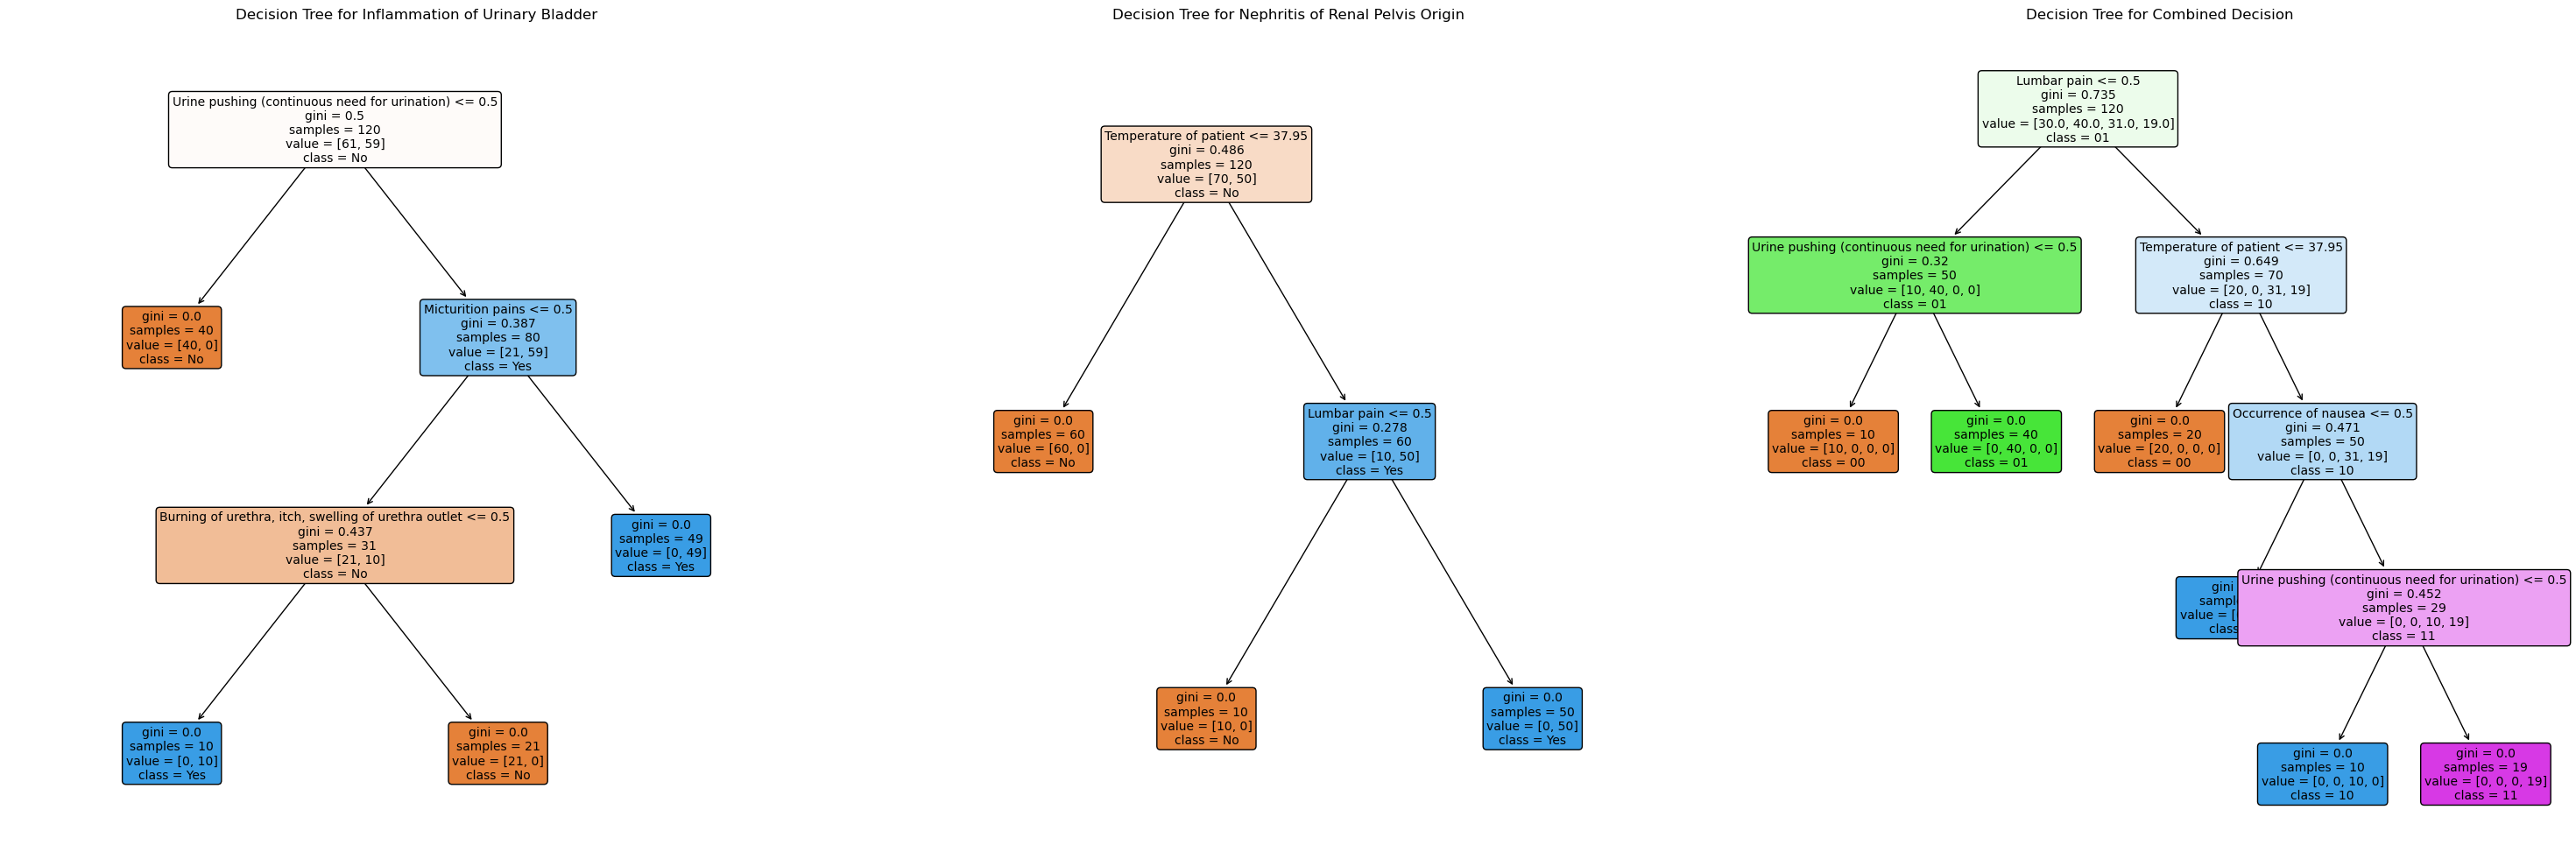

In [5]:
# plot 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

# Inflammation of urinary bladder
plot_tree(clf_inflammation, filled=True, feature_names=X.columns, class_names=["No", "Yes"], rounded=True, ax=axes[0], fontsize=10)
axes[0].set_title('Decision Tree for Inflammation of Urinary Bladder')

# Nephritis of renal pelvis origin
plot_tree(clf_nephritis, filled=True, feature_names=X.columns, class_names=["No", "Yes"], rounded=True, ax=axes[1], fontsize=10)
axes[1].set_title('Decision Tree for Nephritis of Renal Pelvis Origin')

# Combined Decision
combined_class_names = np.unique(Accute_Inflamations_data["combined_decision"])
plot_tree(clf_combined, filled=True, feature_names=X.columns, class_names=combined_class_names, rounded=True, ax=axes[2], fontsize=10)
axes[2].set_title('Decision Tree for Combined Decision')

plt.tight_layout()
plt.show()

### (c) Convert the decision rules

In [6]:
'''https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html'''
def tree_to_pseudo(tree, feature_names):

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                    print(indent,"}")
        else:
            print(indent,"return " + str(value[node]))
    
    recurse(left, right, threshold, features, 0)

# Convert the decision trees to pseudocode
print("\nDecision Tree for Inflammation of Urinary Bladder:")
tree_to_pseudo(clf_inflammation, X.columns.tolist())

print("\nDecision Tree for Nephritis of Renal Pelvis Origin:")
tree_to_pseudo(clf_nephritis, X.columns.tolist())

print("\nDecision Tree for Combined Decision:")
tree_to_pseudo(clf_combined, X.columns.tolist())


Decision Tree for Inflammation of Urinary Bladder:
 if ( Urine pushing (continuous need for urination) <= 0.5 ) {
   return [[1. 0.]]
 } else {
   if ( Micturition pains <= 0.5 ) {
     if ( Burning of urethra, itch, swelling of urethra outlet <= 0.5 ) {
       return [[0. 1.]]
     } else {
       return [[1. 0.]]
     }
   } else {
     return [[0. 1.]]
   }
 }

Decision Tree for Nephritis of Renal Pelvis Origin:
 if ( Temperature of patient <= 37.95000076293945 ) {
   return [[1. 0.]]
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[1. 0.]]
   } else {
     return [[0. 1.]]
   }
 }

Decision Tree for Combined Decision:
 if ( Lumbar pain <= 0.5 ) {
   if ( Urine pushing (continuous need for urination) <= 0.5 ) {
     return [[1. 0. 0. 0.]]
   } else {
     return [[0. 1. 0. 0.]]
   }
 } else {
   if ( Temperature of patient <= 37.95000076293945 ) {
     return [[1. 0. 0. 0.]]
   } else {
     if ( Occurrence of nausea <= 0.5 ) {
       return [[0. 0. 1. 0.]]
     } else {
    

### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability

In [7]:
# Splitting the dataset
X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(X, y_inflammation, test_size=0.2, random_state=42)
X_train_neph, X_test_neph, y_train_neph, y_test_neph = train_test_split(X, y_nephritis, test_size=0.2, random_state=42)

# Pre-define a list of alpha values
ccp_alpha_values = np.linspace(0, 0.02, 100)

# the parameter grid
param_grid = {'ccp_alpha': ccp_alpha_values}

# "Inflammation of urinary bladder"
grid_search_inf = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, criterion='entropy'), param_grid=param_grid, cv=5)
grid_search_inf.fit(X_train_inf, y_train_inf)
best_alpha_inf = grid_search_inf.best_params_['ccp_alpha']

# "Nephritis of renal pelvis origin"
grid_search_neph = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, criterion='entropy'), param_grid=param_grid, cv=5)
grid_search_neph.fit(X_train_neph, y_train_neph)
best_alpha_neph = grid_search_neph.best_params_['ccp_alpha']

# Retraining decision trees 
dt_pruned_inf_best = DecisionTreeClassifier(random_state=42, criterion='entropy', ccp_alpha=best_alpha_inf)
dt_pruned_inf_best.fit(X_train_inf, y_train_inf)

dt_pruned_neph_best = DecisionTreeClassifier(random_state=42, criterion='entropy', ccp_alpha=best_alpha_neph)
dt_pruned_neph_best.fit(X_train_neph, y_train_neph)

best_alpha_inf, best_alpha_neph

(0.0, 0.0)

In [8]:
print("\nOptimally Pruned Decision Tree for Inflammation of Urinary Bladder (Best Alpha = {}):".format(best_alpha_inf))
tree_to_pseudo(dt_pruned_inf_best, X.columns.tolist())

print("\nOptimally Pruned Decision Tree for Nephritis of Renal Pelvis Origin (Best Alpha = {}):".format(best_alpha_neph))
tree_to_pseudo(dt_pruned_neph_best, X.columns.tolist())


Optimally Pruned Decision Tree for Inflammation of Urinary Bladder (Best Alpha = 0.0):
 if ( Urine pushing (continuous need for urination) <= 0.5 ) {
   return [[1. 0.]]
 } else {
   if ( Micturition pains <= 0.5 ) {
     if ( Burning of urethra, itch, swelling of urethra outlet <= 0.5 ) {
       return [[0. 1.]]
     } else {
       return [[1. 0.]]
     }
   } else {
     return [[0. 1.]]
   }
 }

Optimally Pruned Decision Tree for Nephritis of Renal Pelvis Origin (Best Alpha = 0.0):
 if ( Temperature of patient <= 37.95000076293945 ) {
   return [[1. 0.]]
 } else {
   if ( Lumbar pain <= 0.5 ) {
     return [[1. 0.]]
   } else {
     return [[0. 1.]]
   }
 }


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [9]:
variables_file = '../Data/communities_name.txt'
variables = []
with open(variables_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if (line.startswith('@attribute')):
            variables.append(line.split(" ")[1])

In [10]:
len(variables)

128

In [11]:
Communities_and_Crime = pd.read_csv('../Data/communities.csv', sep=",", header=None, names=variables, na_values='?')
# ignore the non-predictive attributes
Communities_and_Crime = Communities_and_Crime.iloc[:, 5:]

In [12]:
print(Communities_and_Crime.shape)
Communities_and_Crime.head(2)

(1994, 123)


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67


In [13]:
community_and_Crime_Train = Communities_and_Crime[:1495]
print(community_and_Crime_Train.shape)
# community_and_Crime_Train.head()

(1495, 123)


In [14]:
community_and_Crime_Test = Communities_and_Crime[1495:]
print(community_and_Crime_Test.shape)
# community_and_Crime_Test.head()

(499, 123)


### (b) Missing values

In [15]:
# calculate mean for each columns
community_and_Crime_data_means = Communities_and_Crime.mean()
for i in range(0, len(community_and_Crime_data_means)):
    community_and_Crime_data_means[i] = round(community_and_Crime_data_means[i], 2)

# Fill the missing value with mean of that column
Communities_and_Crime = Communities_and_Crime.fillna(community_and_Crime_data_means)

In [16]:
Communities_and_Crime.head(2)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.50,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.16,0.08,0.7,0.44,0.00,0.20,0.67


In [17]:
# Update training data
community_and_Crime_Train = Communities_and_Crime[:1495]
community_and_Crime_Train.head(2)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.50,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.16,0.08,0.7,0.44,0.00,0.20,0.67


In [18]:
# Update testing data
community_and_Crime_Test = Communities_and_Crime[1495:]
community_and_Crime_Test.head(2)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,0.0,0.20,0.03,0.91,0.23,0.05,0.15,0.19,0.09,0.42,...,0.01,0.23,0.73,0.16,0.08,0.7,0.44,0.0,0.2,0.12
1496,0.0,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.16,0.08,0.7,0.44,0.0,0.2,0.11


### (c) Plot a correlation matrix 

In [19]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = Communities_and_Crime.corr()
corr.style.background_gradient()

### (d) Calculate the Coefficient of Variation CV

In [20]:
Coefficient_of_Variation_CV = Communities_and_Crime.apply(lambda columns : columns.std() / columns.mean(), axis=0)

In [21]:
pd.set_option('display.max_rows', None)
Coefficient_of_Variation_CV

population               2.203503
householdsize            0.353298
racepctblack             1.410920
racePctWhite             0.323782
racePctAsian             1.359162
racePctHisp              1.614278
agePct12t21              0.365840
agePct12t29              0.290693
agePct16t24              0.495161
agePct65up               0.423442
numbUrban                2.001744
pctUrban                 0.638849
medIncome                0.579753
pctWWage                 0.327710
pctWFarmSelf             0.700030
pctWInvInc               0.359240
pctWSocSec               0.368513
pctWPubAsst              0.699031
pctWRetire               0.349639
medFamInc                0.527732
perCapInc                0.545633
whitePerCap              0.507552
blackPerCap              0.589469
indianPerCap             0.809685
AsianPerCap              0.606194
OtherPerCap              0.670650
HispPerCap               0.473960
NumUnderPov              2.304970
PctPopUnderPov           0.753980
PctLess9thGrad

### (e) Scatter plots and box plots for highest CV features

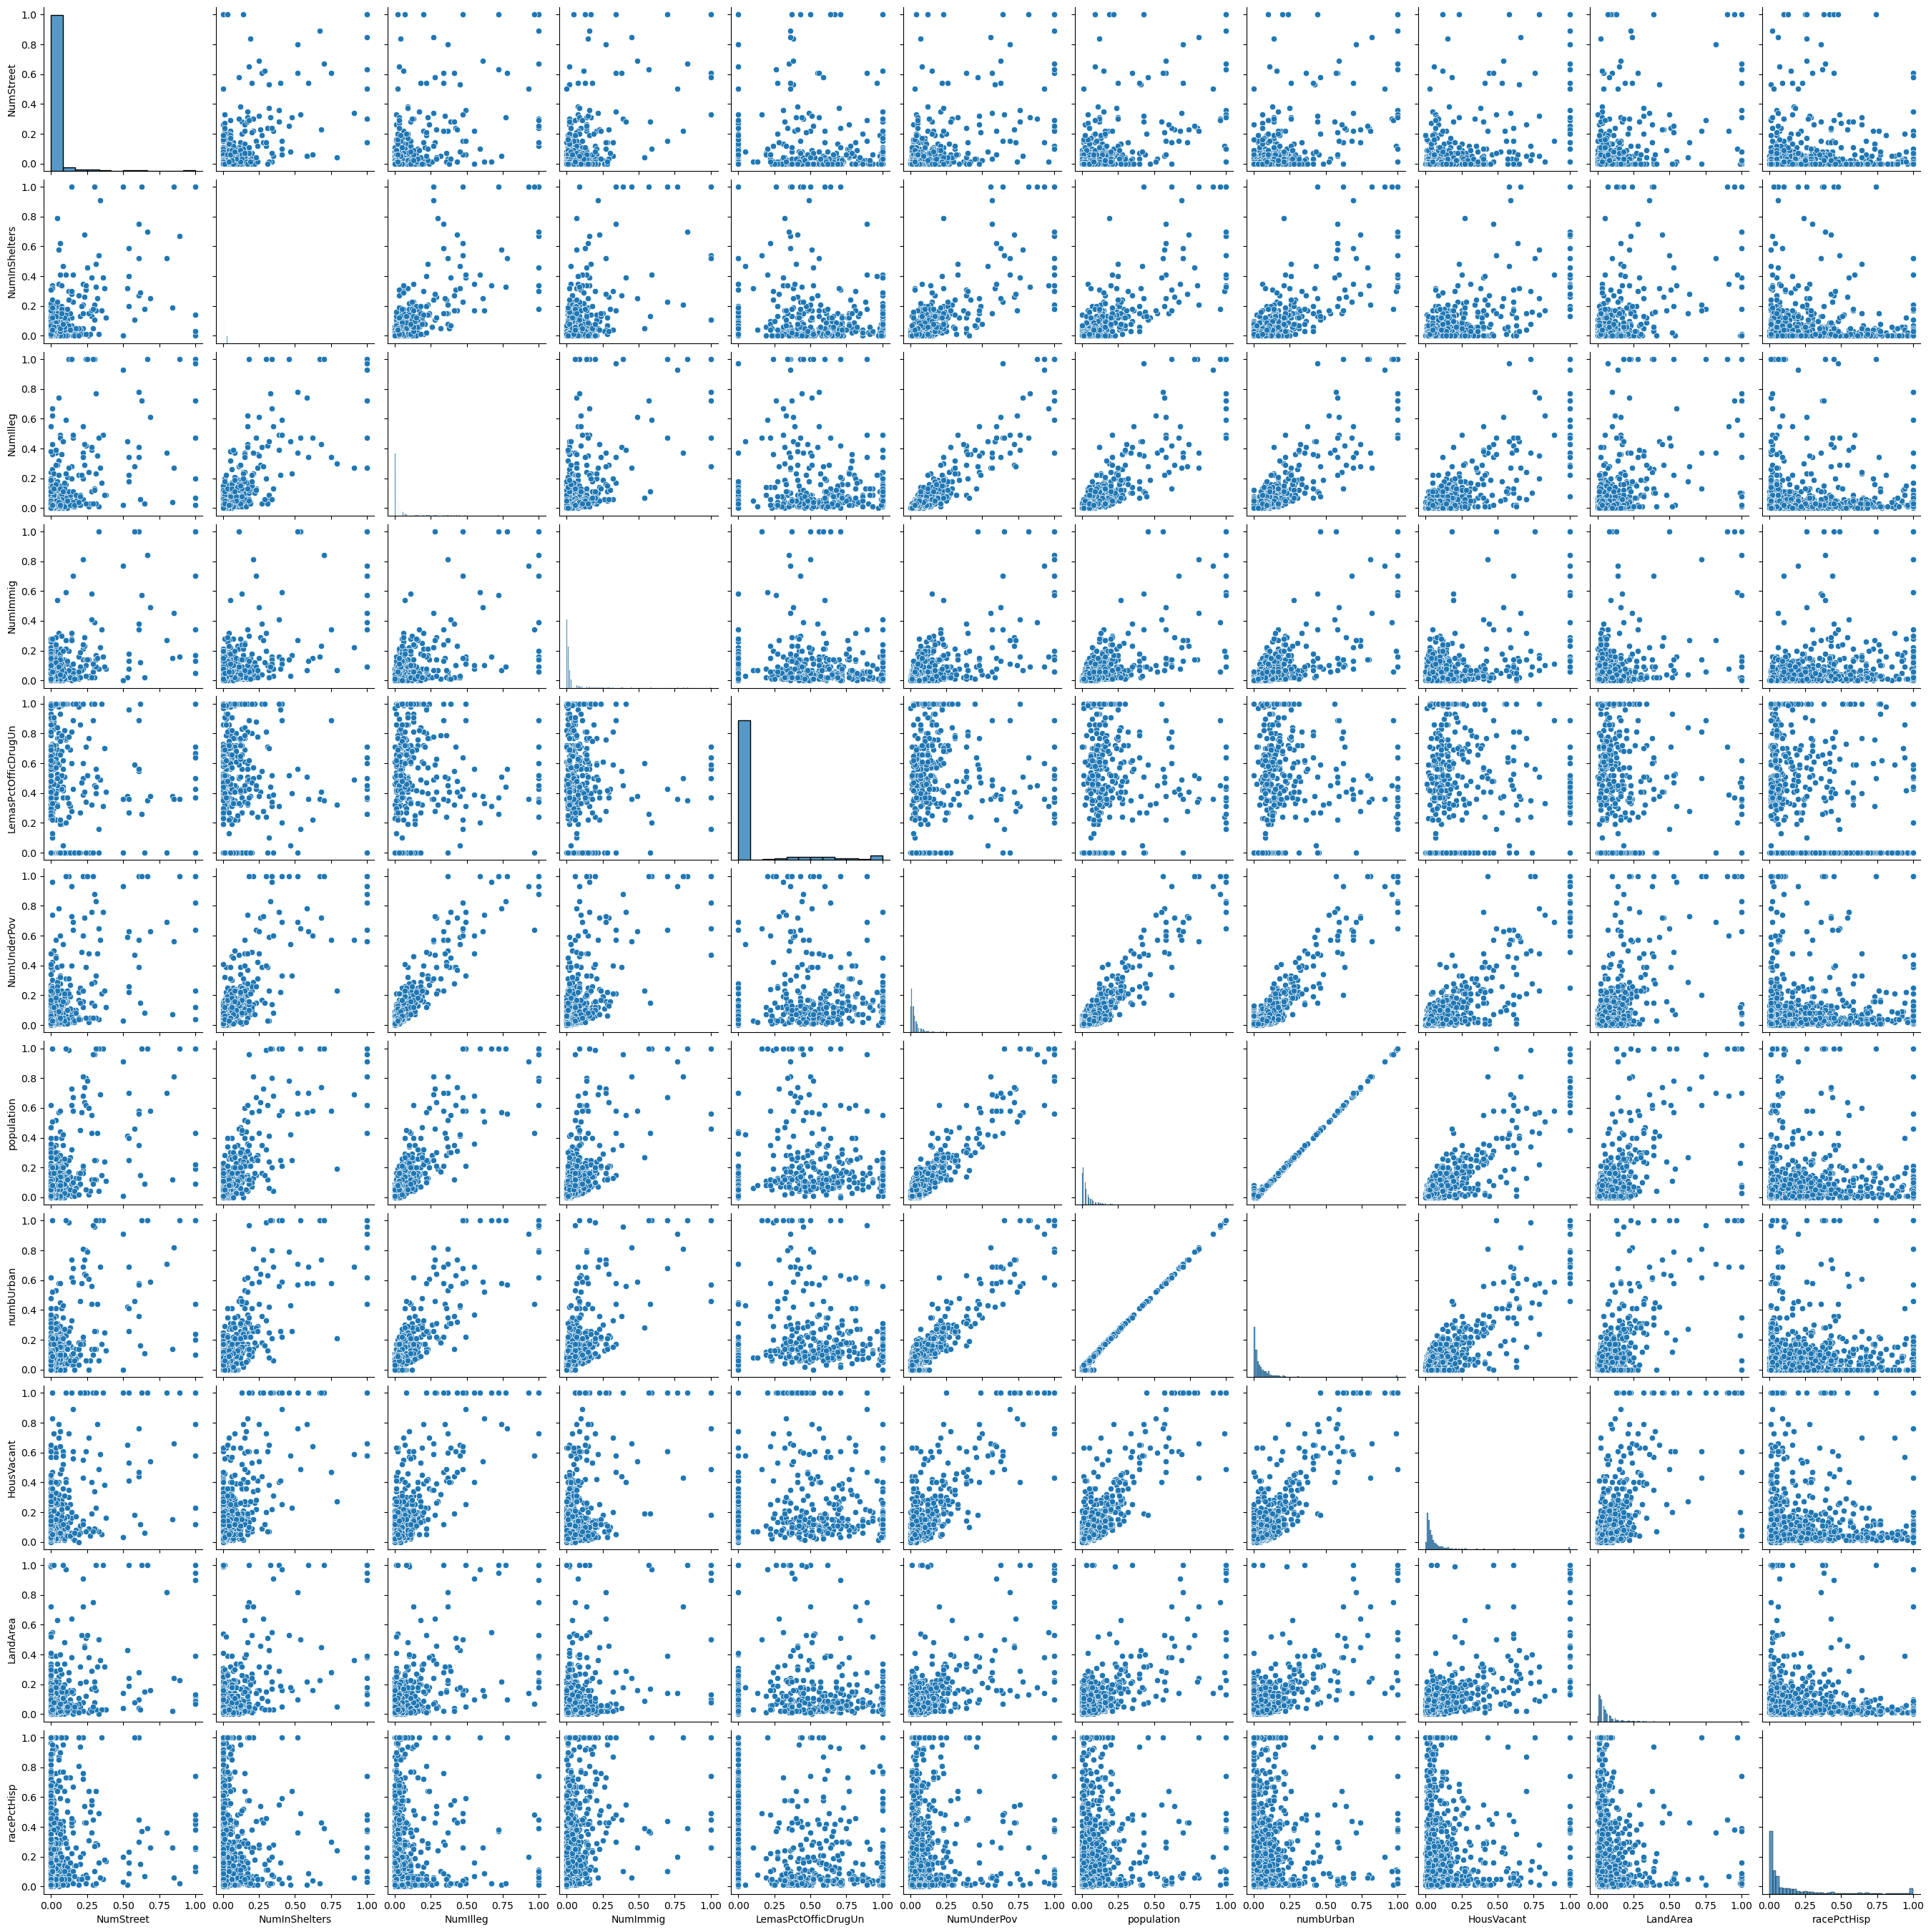

In [22]:
top_n = int(np.floor(np.sqrt(128)))
top_features = Coefficient_of_Variation_CV.nlargest(top_n).index.tolist()
# Scatter plots for the top features
sns.pairplot(Communities_and_Crime[top_features])
plt.show()

The 'numbUrban' and 'population' seems to show a strong, positive linear association. The 'NumUnderPov' and 'population'; 'Numilleg' and'population'; 'Numilleg' and 'numbUrban' as well as many other features seem to show positive linear associations. 

We are able to see strong correlation among features as stated above, but it is hard to detect the significance of features just by the scatter plots.

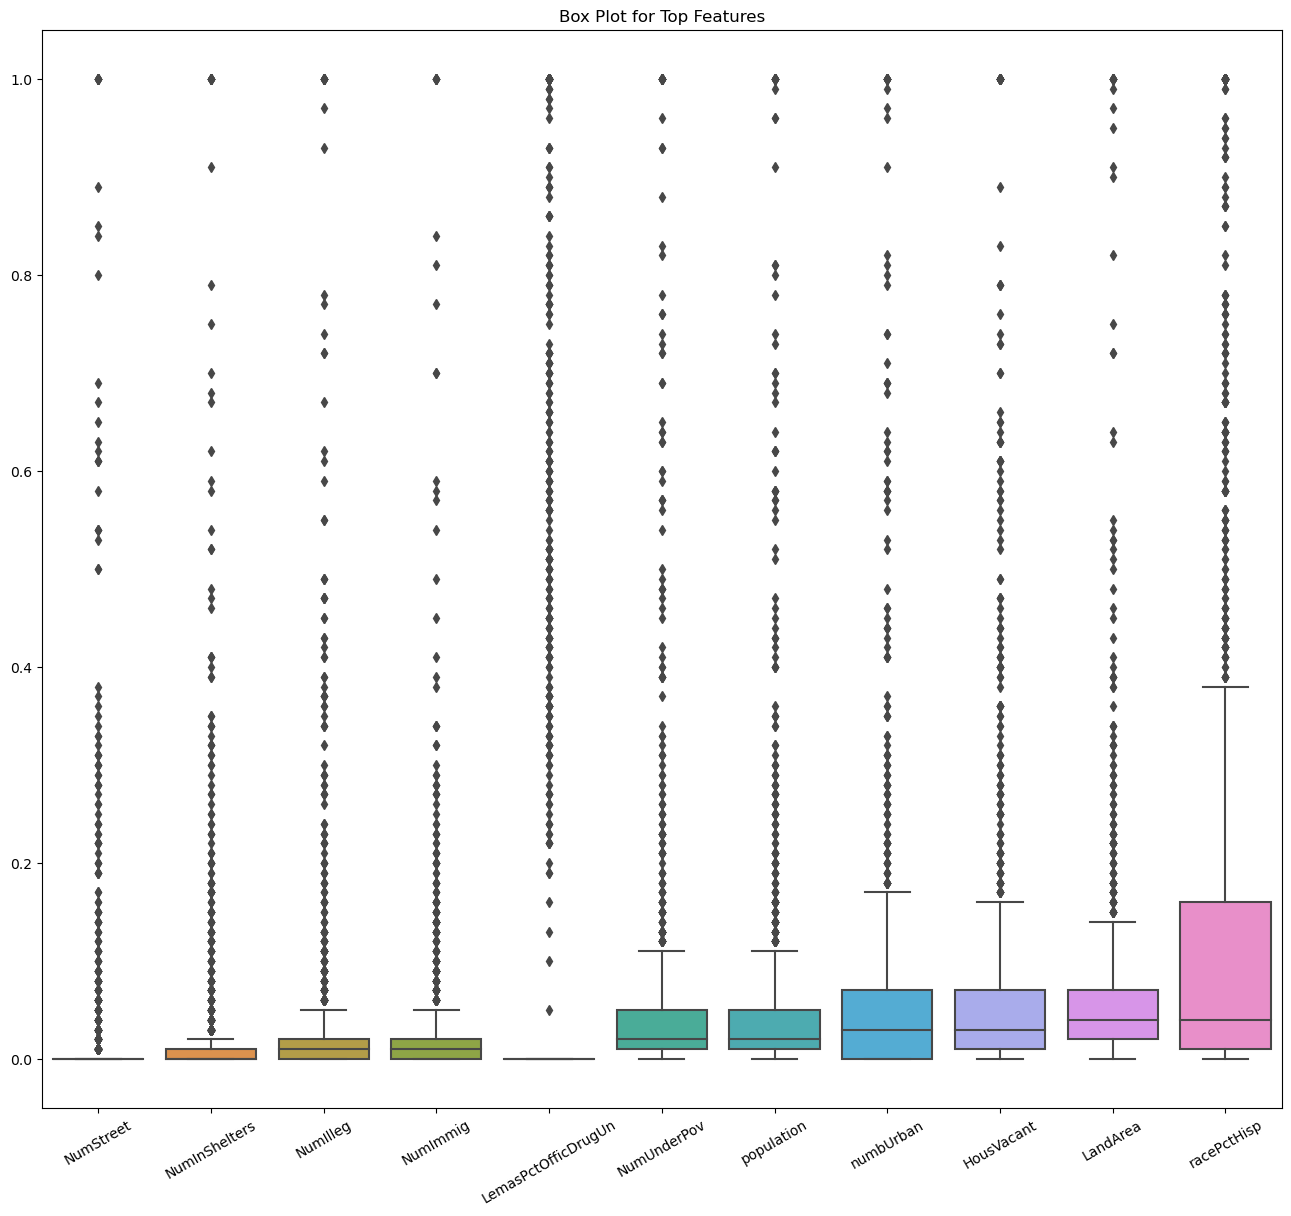

In [23]:
# Box plots for the top features
plt.figure(figsize=(16, 14))
sns.boxplot(data=Communities_and_Crime[top_features])
plt.title('Box Plot for Top Features')
plt.xticks(rotation=30)
plt.show()

### (f) Fit a linear model

In [25]:
X_train = community_and_Crime_Train.iloc[:, :-1]  # Features (all columns except the last one)
y_train = community_and_Crime_Train.iloc[:, -1]   # Target variable (last column)

X_Test = community_and_Crime_Test.iloc[:, :-1]  
y_Test = community_and_Crime_Test.iloc[:, -1]   

regr = LinearRegression()

# Fit the model
regr.fit(X_train, y_train)

# Make predictions 
y_pred = regr.predict(X_Test)

# The test error
test_error = mean_squared_error(y_Test, y_pred)
print(f"Test Error (MSE): {test_error}")

Test Error (MSE): 1.6261062758309066e+18


### (g) Fit a ridge regression model

In [26]:
# alpha values for Ridge Regression
alphas = 10**np.linspace(10,-2,100)*0.5

# Ridge regression 
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# The alpha parameter chosen by CV
best_alpha = ridge_cv.alpha_
print(f"Best alpha: {best_alpha}")

# Predict using the test set
y_pred = ridge_cv.predict(X_Test)

# Calculate the test error
test_error = mean_squared_error(y_Test, y_pred)
print(f"Test Error (MSE): {test_error}")

Best alpha: 2.320794416806386
Test Error (MSE): 0.017596991645988998


### (h) Fit a LASSO model

In [27]:
# LASSO with the original features
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# The alpha parameter chosen by CV
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

# LASSO Prediction
y_pred = lasso_cv.predict(X_Test)

# test error
test_error = mean_squared_error(y_Test, y_pred)
print(f"Original features Test Error (MSE): {test_error}")

# variables selected by the model
coef = lasso_cv.coef_
selected_features = [X_train.columns[i] for i in range(len(coef)) if coef[i] != 0]
print("Variables selected by the LASSO model(original):", selected_features)

Best alpha: 0.005
Original features Test Error (MSE): 0.018805364920055034
Variables selected by the LASSO model(original): ['racePctWhite', 'pctUrban', 'MalePctDivorce', 'PctKids2Par', 'PctIlleg', 'PctPersDenseHous', 'HousVacant', 'PctVacantBoarded']


In [28]:
# standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_Test)

# LASSO with standardized features
lasso_cv_scaled = LassoCV(alphas=alphas, cv=5, random_state=42)
lasso_cv_scaled.fit(X_train_scaled, y_train)

# The alpha parameter chosen by CV
best_alpha = lasso_cv_scaled.alpha_
print(f"Best alpha: {best_alpha}")

# LASSO Prediction
y_pred_scaled = lasso_cv_scaled.predict(X_test_scaled)

# test error
test_error_scaled = mean_squared_error(y_Test, y_pred_scaled)
print(f"Standardized features Test Error (MSE): {test_error_scaled}")

# variables selected by the model
coef_scaled = lasso_cv_scaled.coef_
selected_features_scaled = [X_train.columns[i] for i in range(len(coef_scaled)) if coef_scaled[i] != 0]
print("Variables selected by the LASSO model (standardized):", selected_features_scaled)

Best alpha: 0.005
Standardized features Test Error (MSE): 0.017381127726917415
Variables selected by the LASSO model (standardized): ['racepctblack', 'racePctWhite', 'agePct12t29', 'pctUrban', 'pctWInvInc', 'pctWPubAsst', 'pctWRetire', 'AsianPerCap', 'MalePctDivorce', 'PctKids2Par', 'PctWorkMom', 'PctIlleg', 'PctPersDenseHous', 'PctHousLess3BR', 'HousVacant', 'PctHousOccup', 'PctVacantBoarded', 'MedRentPctHousInc', 'MedOwnCostPctIncNoMtg', 'NumStreet', 'PctForeignBorn', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn']


In [29]:
print(f"Original Features: {test_error}")
print(f"Standardized Features: {test_error_scaled}")

Original Features: 0.018805364920055034
Standardized Features: 0.017381127726917415


Based on the MSE obtained from test data, the MSE for standardized features do not change too much in Lasso regression.

### (i) Fit a PCR model

In [30]:
def PCRCV(X, y, n_folds, n_components_range):
    # cross-validation
    kf = KFold(n_folds, shuffle=True, random_state=1495)
    
    # store average MSE for each number of components
    mse_scores = []

    for m in n_components_range:
        # Create pipeline with PCA and linear regression
        pca_ols_pipeline = make_pipeline(PCA(n_components=m), LinearRegression())
        
        # Compute cross-validated MSE scores
        mse_score = -cross_val_score(pca_ols_pipeline, X, y, cv=kf, scoring='neg_mean_squared_error').mean()
        mse_scores.append((m, mse_score))
    
    return mse_scores

In [31]:
# range of components
n_components_range = range(1, X_train.shape[1] + 1)

# average validation MSE for each number of components
mse_scores = PCRCV(X_train, y_train, 5, n_components_range)

# Find the lowest MSE
best_n_components, best_mse_score = min(mse_scores, key=lambda x: x[1])

# best number of components
print(f"Best M = {best_n_components}, with minimum cross-validated MSE {best_mse_score}.")

# Fit PCA and the linear model 
pca = PCA(n_components=best_n_components).fit(X_train)
pca_train = pca.transform(X_train)
pca_test = pca.transform(X_Test)

ols_reg = LinearRegression().fit(pca_train, y_train)

# Predict
test_pred = ols_reg.predict(pca_test)
# MSE 
test_mse = mean_squared_error(y_Test, test_pred)
print(f"PCR model's test MSE: {test_mse}")

Best M = 97, with minimum cross-validated MSE 0.01949900990724767.
PCR model's test MSE: 0.01845472706456332


### (j) Fit a boosting tree

In [32]:
TrainX = np.array(X_train)
TrainY = np.array(y_train)
TestX = np.array(X_Test)
TestY = np.array(y_Test)  

# XGBoost model and parameters for GridSearchCV
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')
reg_alpha_params = {'reg_alpha': alphas}

# find the best alpha
grid_search_cv = GridSearchCV(xgb_regressor, reg_alpha_params, cv=10, scoring='neg_mean_squared_error')
grid_search_cv.fit(TrainX, TrainY.flatten())
best_reg_alpha = grid_search_cv.best_params_['reg_alpha']
best_rmse = np.sqrt(-grid_search_cv.best_score_)
print(f"Best alpha: {best_reg_alpha} with RMSE: {best_rmse}")

# Fit XGBoost model
optimized_xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=best_reg_alpha)
optimized_xgb_regressor.fit(TrainX, TrainY)

# Predict 
predictions = optimized_xgb_regressor.predict(TestX)
# MSE 
test_mse = mean_squared_error(TestY, predictions)
print('Test MSE:', test_mse)

Best alpha: 3.0679536367065814 with RMSE: 0.1422877714562596
Test MSE: 0.01813328327751715


### Reference

* [Correlation-matrix](https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas)
* [Kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
* [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
* [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
* [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [xgboost](https://xgboost.readthedocs.io/en/stable/)
* [Model_evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Gradient-boosting](https://machinelearningmastery.com/gradient-boosting-machine-ensemble-in-python/)